In [13]:
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt
import seaborn as sns

# Converting users.json to users.csv and performaing data cleaning

In [14]:
with open('users.json', 'r') as file:
    json_data = [json.loads(line) for line in file]

users_df = pd.json_normalize(json_data)

In [15]:
users_df.head()

,active,role,signUpSource,state,_id.$oid,createdDate.$date,lastLogin.$date
0,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
1,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
2,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
3,True,consumer,Email,WI,5ff1e1eacfcf6c399c274ae6,1609687530554,1.609688e+12
4,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12


In [16]:
users_df.isnull().sum()

active                0
role                  0
signUpSource         48
state                56
_id.$oid              0
createdDate.$date     0
lastLogin.$date      62
dtype: int64

In [17]:
duplicate_users = users_df.duplicated()
print(duplicate_users.sum())

283


There are 283 duplicate rows in this data. Keeping them is redundant as entire rows are duplicate, and I cannot make a primary key using duplicate entries.
Thus, I have dropped these rows.

In [18]:
users_df = users_df.drop_duplicates()

In [19]:
users_df.dtypes

active                  bool
role                  object
signUpSource          object
state                 object
_id.$oid              object
createdDate.$date      int64
lastLogin.$date      float64
dtype: object

I have typecasted some columns to ensure they match the sql import wizard defaults

In [20]:
users_df['active'] = users_df['active'].astype(int)

In [21]:
users_df['lastLogin.$date'] = users_df['lastLogin.$date'].fillna(users_df['createdDate.$date'])

In [22]:
users_df['createdDate.$date'] = pd.to_datetime(users_df['createdDate.$date'], unit='ms')
users_df['lastLogin.$date'] = pd.to_datetime(users_df['lastLogin.$date'], unit='ms')

users_df['createdDate.$date'] = users_df['createdDate.$date'].dt.strftime('%Y-%m-%d %H:%M:%S')
users_df['lastLogin.$date'] = users_df['lastLogin.$date'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [23]:
csv_name = 'users.csv'
users_df.to_csv(csv_name, index=False)

# Converting brands.json to brands.csv and performing data cleaning

In [24]:
with open('brands.json', 'r') as file:
    json_data = [json.loads(line) for line in file]

brands_df = pd.json_normalize(json_data)

In [25]:
brands_df.head()

,barcode,category,categoryCode,name,topBrand,_id.$oid,cpg.$id.$oid,cpg.$ref,brandCode
0,511111019862,Baking,BAKING,test brand @1612366101024,False,601ac115be37ce2ead437551,601ac114be37ce2ead437550,Cogs,NaN
1,511111519928,Beverages,BEVERAGES,Starbucks,False,601c5460be37ce2ead43755f,5332f5fbe4b03c9a25efd0ba,Cogs,STARBUCKS
2,511111819905,Baking,BAKING,test brand @1612366146176,False,601ac142be37ce2ead43755d,601ac142be37ce2ead437559,Cogs,TEST BRANDCODE @1612366146176
3,511111519874,Baking,BAKING,test brand @1612366146051,False,601ac142be37ce2ead43755a,601ac142be37ce2ead437559,Cogs,TEST BRANDCODE @1612366146051
4,511111319917,Candy & Sweets,CANDY_AND_SWEETS,test brand @1612366146827,False,601ac142be37ce2ead43755e,5332fa12e4b03c9a25efd1e7,Cogs,TEST BRANDCODE @1612366146827


In [26]:
brands_df.isnull().sum()

barcode           0
category        155
categoryCode    650
name              0
topBrand        612
_id.$oid          0
cpg.$id.$oid      0
cpg.$ref          0
brandCode       234
dtype: int64

In [27]:
brands_df['barcode'] = brands_df['barcode'].astype(int)

In [28]:
brands_df.dtypes

barcode          int64
category        object
categoryCode    object
name            object
topBrand        object
_id.$oid        object
cpg.$id.$oid    object
cpg.$ref        object
brandCode       object
dtype: object

In [29]:
brands_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   barcode       1167 non-null   int64 
 1   category      1012 non-null   object
 2   categoryCode  517 non-null    object
 3   name          1167 non-null   object
 4   topBrand      555 non-null    object
 5   _id.$oid      1167 non-null   object
 6   cpg.$id.$oid  1167 non-null   object
 7   cpg.$ref      1167 non-null   object
 8   brandCode     933 non-null    object
dtypes: int64(1), object(8)
memory usage: 82.2+ KB


In [30]:
brands_df.duplicated().sum()

0

Here, I noticed that a lot of brands are not recognized as top brands, but they are also not given the False boolean value. Thus, I set it and typecasted it to binary.

Also, there are lot of unnecessary blank spaces in the columns which causes issue to the importing process in SQL. I have thus stripped the blanks.

I noticed a lot of characters which are beyond the ordinals recognized by SQL. I thus removed them. A way to incorporate them is to use them on Windows, as the Windows codec on MS SQL server allows these characters to parse.

In [62]:
brands_df['topBrand'] = brands_df['topBrand'].fillna(False)
brands_df['topBrand'] = brands_df['topBrand'].astype(int)

In [33]:
brands_df_obj = brands_df.select_dtypes(object)
brands_df[brands_df_obj.columns] = brands_df_obj.apply(lambda x: x.str.strip())

In [34]:
brands_df.replace({r'[^\x00-\x7F]+':''}, regex= True, inplace = True)

In [35]:
csv_name2 = 'brands.csv'
brands_df.to_csv(csv_name2, encoding = 'utf-8', index=False)

# Converting receipts.json to receipts.csv and performing data cleaning

In this part, I found that there is an entire column which is a json file on its own. There are two ways to go about this. One is to keep that column as it is in the dataframe and try to access it in SQL subqueries.

This can be done, but then the complexity of the SQL queries increases exponentially since the json is very big with a lot of columns.

I thus felt it would be better to explode the inner json in python and would lead to a better schema in SQL as well. This did prove to be true in the end, as the relational schema was quite straightforward after doing this.

In [63]:
def read_json(filename):
    with open(filename, "r") as f:
        try:
            content = f.read()
            data_list = [json.loads(obj) for obj in content.split('\n') if obj.strip()]
            return data_list
        except json.JSONDecodeError as e:
            raise Exception(f"Reading {filename} file encountered an error: {e}")

try:
    data_list = read_json("receipts.json")
except Exception as e:
    print(e)

In [37]:
def normalize_json(data):
    new_data = {}
    for key, value in data.items():
        if not isinstance(value, dict):
            new_data[key] = value
        else:
            for k, v in value.items():
                new_data[key + "_" + k] = v
    return new_data

normalized_data = [normalize_json(data) for data in data_list]

receipts_df = pd.DataFrame(normalized_data)

In [38]:
receipts_df.head()

,_id_$oid,bonusPointsEarned,bonusPointsEarnedReason,createDate_$date,dateScanned_$date,finishedDate_$date,modifyDate_$date,pointsAwardedDate_$date,pointsEarned,purchaseDate_$date,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedu...",1609687531000,1609687531000,1.609688e+12,1609687536000,1.609688e+12,500.0,1.609632e+12,5.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,26.00,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",1609687483000,1609687483000,1.609687e+12,1609687488000,1.609687e+12,150.0,1.609601e+12,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,11.00,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,1609687537000,1609687537000,NaN,1609687542000,NaN,5,1.609632e+12,1.0,"[{'needsFetchReview': False, 'partnerItemId': ...",REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,1609687534000,1609687534000,1.609688e+12,1609687539000,1.609688e+12,5.0,1.609632e+12,4.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,28.00,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5.0,All-receipts receipt bonus,1609687506000,1609687506000,1.609688e+12,1609687511000,1.609688e+12,5.0,1.609601e+12,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.00,5ff1e194b6a9d73a3a9f1052


There were a lot of null values in this json. They all needed to be filled in order to make the SQL processing simpler.

The null dates were set to the minimum available dates.

In [39]:
receipts_df['bonusPointsEarned'] = receipts_df['bonusPointsEarned'].fillna(0)
receipts_df['purchasedItemCount'] = receipts_df['purchasedItemCount'].fillna(0)
receipts_df['totalSpent'] = receipts_df['totalSpent'].fillna(0)
receipts_df['pointsEarned'] = receipts_df['pointsEarned'].fillna(0)
receipts_df['pointsAwardedDate_$date'] = receipts_df['pointsAwardedDate_$date'].fillna(receipts_df['createDate_$date'])
receipts_df['finishedDate_$date'] = receipts_df['finishedDate_$date'].fillna(receipts_df['createDate_$date'])
receipts_df['purchaseDate_$date'] = receipts_df['purchaseDate_$date'].fillna(receipts_df['createDate_$date'])

In [40]:
receipts_df.isnull().sum()

_id_$oid                     0
bonusPointsEarned            0
bonusPointsEarnedReason    575
createDate_$date             0
dateScanned_$date            0
finishedDate_$date           0
modifyDate_$date             0
pointsAwardedDate_$date      0
pointsEarned                 0
purchaseDate_$date           0
purchasedItemCount           0
rewardsReceiptItemList     440
rewardsReceiptStatus         0
totalSpent                   0
userId                       0
dtype: int64

In [41]:
receipts_df.duplicated('_id_$oid').sum()

0

In [42]:
date_columns = ['createDate_$date', 'dateScanned_$date', 'finishedDate_$date',
                'modifyDate_$date', 'pointsAwardedDate_$date', 'purchaseDate_$date']

for column in date_columns:
    receipts_df[column] = pd.to_datetime(receipts_df[column], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')

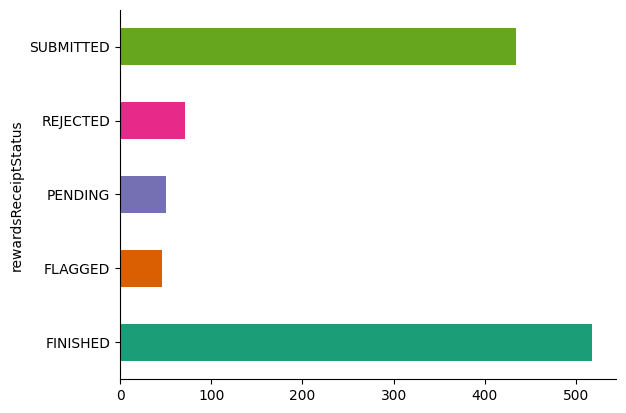

In [43]:
receipts_df.groupby('rewardsReceiptStatus').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [44]:
receipts_df.dtypes

_id_$oid                    object
bonusPointsEarned          float64
bonusPointsEarnedReason     object
createDate_$date            object
dateScanned_$date           object
finishedDate_$date          object
modifyDate_$date            object
pointsAwardedDate_$date     object
pointsEarned                object
purchaseDate_$date          object
purchasedItemCount         float64
rewardsReceiptItemList      object
rewardsReceiptStatus        object
totalSpent                  object
userId                      object
dtype: object

This is where I exploded the inner json file to create a separate dataset by the name Item_List. This contains all the details of the inner json.

I have linked it to the parent file by adding the unique id (_id$oid) so that I can map it back to the parent dataset.

In [46]:
from pandas import json_normalize

receipts_copy = receipts_df.copy()

receipts_copy['rewardsReceiptItemList'] = receipts_copy['rewardsReceiptItemList'].apply(lambda x: x if isinstance(x, list) else [])

receipts_copy = receipts_copy[receipts_copy['rewardsReceiptItemList'].map(len) > 0]

expanded_items_list = json_normalize(data=receipts_copy.explode('rewardsReceiptItemList')['rewardsReceiptItemList'], sep='_')

rewards_receipt_item_list_df = expanded_items_list.copy()
rewards_receipt_item_list_df['_id_$oid'] = receipts_copy['_id_$oid'].reindex(receipts_copy.index.repeat(receipts_copy['rewardsReceiptItemList'].str.len())).reset_index(drop=True)

In [47]:
rewards_receipt_item_list_df.head()

,barcode,description,finalPrice,itemPrice,needsFetchReview,partnerItemId,preventTargetGapPoints,quantityPurchased,userFlaggedBarcode,userFlaggedNewItem,...,originalMetaBriteQuantityPurchased,pointsEarned,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId,_id_$oid
0,4011,ITEM NOT FOUND,26.00,26.00,False,1,True,5.0,4011,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5ff1e1eb0a720f0523000575
1,4011,ITEM NOT FOUND,1,1,NaN,1,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5ff1e1bb0a720f052300056b
2,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,10.00,10.00,True,2,True,1.0,028400642255,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5ff1e1bb0a720f052300056b
3,NaN,NaN,NaN,NaN,False,1,True,NaN,4011,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5ff1e1f10a720f052300057a
4,4011,ITEM NOT FOUND,28.00,28.00,False,1,True,4.0,4011,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5ff1e1ee0a7214ada100056f


This also has a lot of null values and the datatypes needed to be typecasted to the default datatypes of the import wizard.

I cleaned the barcode by removing unnecessary characters which were with the interger number. Also, wherever prices / costs were not given, I filled them to be zero as zero prices make more sense than null prices, in this case.

In [48]:
rewards_receipt_item_list_df['originalMetaBriteItemPrice'].unique()

array([nan, '10.00', '1.00'], dtype=object)

In [49]:
receipts_df = receipts_df.drop(columns=['rewardsReceiptItemList'])

In [50]:
csv_name3 = 'receipts.csv'
receipts_df.to_csv(csv_name3, encoding = 'utf-8', index=False)

In [51]:
rewards_receipt_item_list_df['needsFetchReview'] = rewards_receipt_item_list_df['needsFetchReview'].fillna(False)
rewards_receipt_item_list_df['needsFetchReview'] = rewards_receipt_item_list_df['needsFetchReview'].astype(int)

rewards_receipt_item_list_df['userFlaggedNewItem'] = rewards_receipt_item_list_df['userFlaggedNewItem'].fillna(False)
rewards_receipt_item_list_df['userFlaggedNewItem'] = rewards_receipt_item_list_df['userFlaggedNewItem'].astype(int)

rewards_receipt_item_list_df['deleted'] = rewards_receipt_item_list_df['deleted'].fillna(False)
rewards_receipt_item_list_df['deleted'] = rewards_receipt_item_list_df['deleted'].astype(int)

rewards_receipt_item_list_df['preventTargetGapPoints'] = rewards_receipt_item_list_df['preventTargetGapPoints'].fillna(False)
rewards_receipt_item_list_df['preventTargetGapPoints'] = rewards_receipt_item_list_df['preventTargetGapPoints'].astype(int)

rewards_receipt_item_list_df['competitiveProduct'] = rewards_receipt_item_list_df['competitiveProduct'].fillna(False)
rewards_receipt_item_list_df['competitiveProduct'] = rewards_receipt_item_list_df['competitiveProduct' ].astype(int)

rewards_receipt_item_list_df['pointsEarned'] = rewards_receipt_item_list_df['pointsEarned' ].fillna(0)

In [52]:
rewards_receipt_item_list_df['barcode'] = rewards_receipt_item_list_df['barcode'].str.replace("'",'')
rewards_receipt_item_list_df['barcode'] = rewards_receipt_item_list_df['barcode'].astype(str)
rewards_receipt_item_list_df['barcode'] = rewards_receipt_item_list_df['barcode'].str.replace('nan', '')

In [53]:
rewards_receipt_item_list_df['barcode']

0               4011
1               4011
2       028400642255
3                   
4               4011
            ...     
6936      B07BRRLSVC
6937      B076FJ92M4
6938      B07BRRLSVC
6939      B076FJ92M4
6940      B07BRRLSVC
Name: barcode, Length: 6941, dtype: object

In [54]:
rewards_receipt_item_list_df.isnull().sum()

barcode                                  0
description                            381
finalPrice                             174
itemPrice                              174
needsFetchReview                         0
partnerItemId                            0
preventTargetGapPoints                   0
quantityPurchased                      174
userFlaggedBarcode                    6604
userFlaggedNewItem                       0
userFlaggedPrice                      6642
userFlaggedQuantity                   6642
needsFetchReviewReason                6722
pointsNotAwardedReason                6601
pointsPayerId                         5674
rewardsGroup                          5210
rewardsProductPartnerId               4672
userFlaggedDescription                6736
originalMetaBriteBarcode              6870
originalMetaBriteDescription          6931
brandCode                             4341
competitorRewardsGroup                6666
discountedItemPrice                   1172
originalRec

In [55]:
csv_name4 = 'Item_List.csv'
rewards_receipt_item_list_df.to_csv(csv_name4, encoding = 'utf-8', index=False)